In [108]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [109]:
data = pd.read_csv("cleaned_data_MSAAI_Final.csv")

In [110]:
data.dtypes

holiday                        object
rain_mm_per_hour              float64
snow_mm_per_hour              float64
cloud_coverage_percentage     float64
weather_condition              object
detailed_weather_condition     object
date_time                      object
traffic_volume                float64
temperature_fahrenheit        float64
hour                            int64
day_of_week                     int64
month                           int64
temp_category                  object
traffic_volume_lag1           float64
temp_category_mean_encoded    float64
dtype: object

In [111]:
# X = data[['holiday', 'rain_mm_per_hour', 'snow_mm_per_hour', 'cloud_coverage_percentage', 
#           'temperature_fahrenheit', 'hour', 'day_of_week', 'month', 'temp_category', 
#           'traffic_volume_lag1', 'temp_category_mean_encoded']]
# y = data['traffic_volume']
# Extract features and target variable
# Extract features and target variable
X = data[['holiday', 'rain_mm_per_hour', 'snow_mm_per_hour', 'cloud_coverage_percentage', 
          'temperature_fahrenheit', 'hour', 'month', 'temp_category', 
          'temp_category_mean_encoded']]
y = data['day_of_week']  # Target feature to predict

# One-hot encode the target variable (day of the week)
y_encoded = pd.get_dummies(y, prefix='day')

# Define categorical and numerical column names
categorical_cols = ['holiday', 'temp_category']
numerical_cols = ['rain_mm_per_hour', 'snow_mm_per_hour', 'cloud_coverage_percentage', 
                  'temperature_fahrenheit', 'hour', 'month', 
                  'temp_category_mean_encoded']

# Preprocessing: One-hot encode categorical variables and standardize numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X_train.shape[1], 1), return_sequences=True))  # First RNN layer
model.add(SimpleRNN(30, return_sequences=False))  # Second RNN layer
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))  # Output layer with 7 units (one for each day of the week)

# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('RNN_model.h5', monitor='val_loss', save_best_only=True, verbose=0)

# Reshape input data to 3D (samples, timesteps, features) for RNN
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test_reshaped, y_test), 
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
accuracy = model.evaluate(X_test_reshaped, y_test)[1]
print(history.history.keys())

Epoch 1/100
1205/1205 [==============================] - 5s 3ms/step - loss: 1.9831 - accuracy: 0.1450 - val_loss: 1.9656 - val_accuracy: 0.1388
Epoch 2/100
1205/1205 [==============================] - 4s 4ms/step - loss: 1.9828 - accuracy: 0.1413 - val_loss: 1.9769 - val_accuracy: 0.1440
Epoch 3/100
1205/1205 [==============================] - 4s 3ms/step - loss: 1.9805 - accuracy: 0.1417 - val_loss: 1.9633 - val_accuracy: 0.1486
Epoch 4/100
1205/1205 [==============================] - 4s 3ms/step - loss: 1.9820 - accuracy: 0.1416 - val_loss: 1.9725 - val_accuracy: 0.1440
Epoch 5/100
1205/1205 [==============================] - 4s 3ms/step - loss: 1.9815 - accuracy: 0.1431 - val_loss: 1.9575 - val_accuracy: 0.1440
Epoch 6/100
1205/1205 [==============================] - 4s 3ms/step - loss: 1.9788 - accuracy: 0.1458 - val_loss: 1.9840 - val_accuracy: 0.1440
Epoch 7/100
1205/1205 [==============================] - 4s 3ms/step - loss: 1.9810 - accuracy: 0.1396 - val_loss: 1.9667 - val_ac

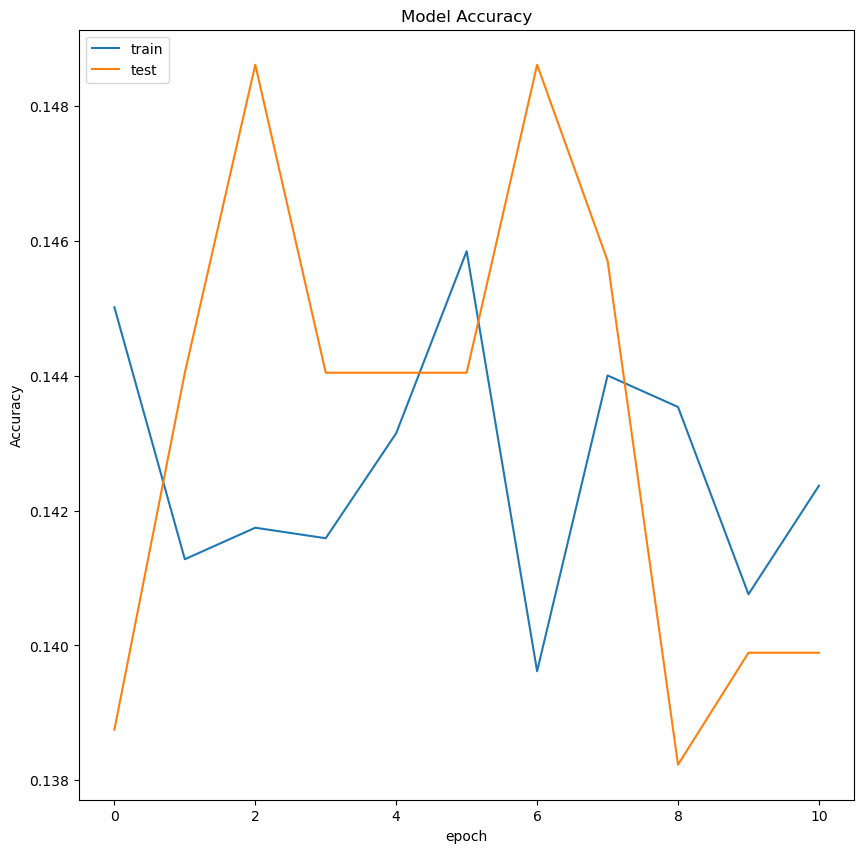

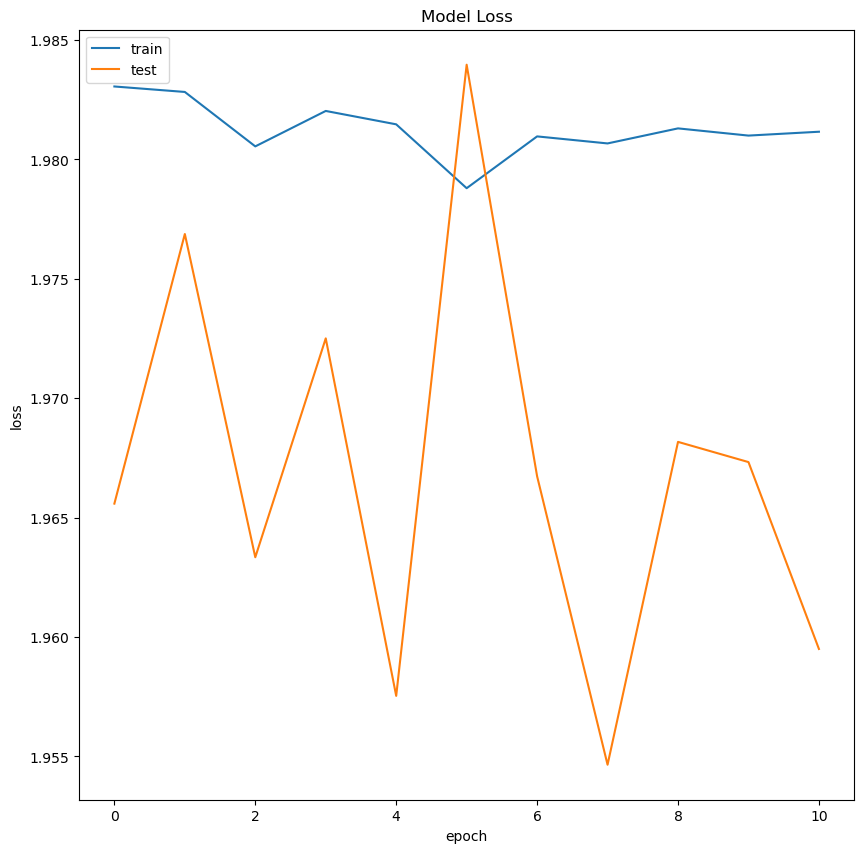

In [112]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("RNN_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("RNN_loss1.png")

In [113]:
# Predict
predictions = model.predict(X_test_reshaped)
predictions

302/302 [==============================] - 1s 1ms/step


array([[0.14240684, 0.13532388, 0.15089215, ..., 0.1770885 , 0.12977773,
        0.11000346],
       [0.14240684, 0.13532387, 0.15089217, ..., 0.1770885 , 0.1297777 ,
        0.11000346],
       [0.1424068 , 0.1353239 , 0.15089217, ..., 0.17708851, 0.12977771,
        0.11000346],
       ...,
       [0.14240682, 0.13532387, 0.15089215, ..., 0.1770885 , 0.12977773,
        0.11000344],
       [0.14240682, 0.13532387, 0.15089215, ..., 0.1770885 , 0.1297777 ,
        0.11000344],
       [0.1424068 , 0.1353239 , 0.15089215, ..., 0.17708848, 0.12977771,
        0.11000346]], dtype=float32)

In [118]:
# for i in predictions:
#     print(i)


302/302 [==============================] - 0s 1ms/step


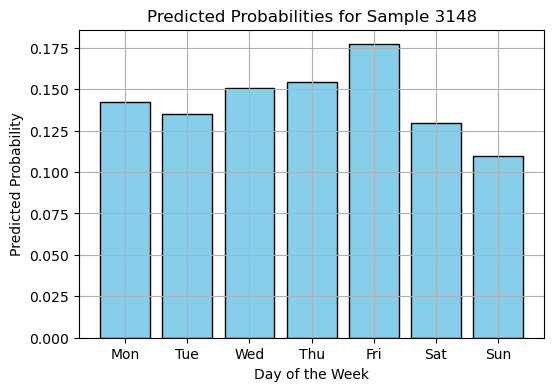

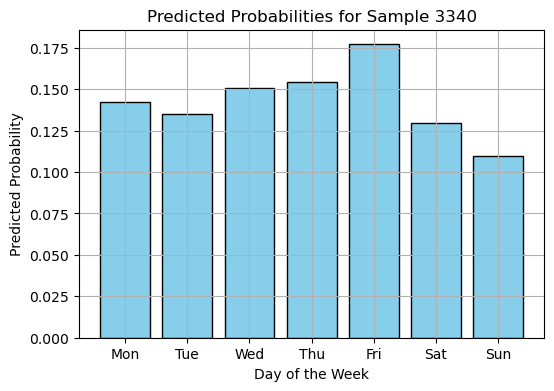

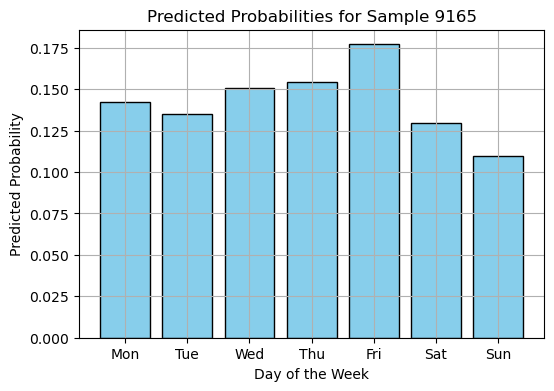

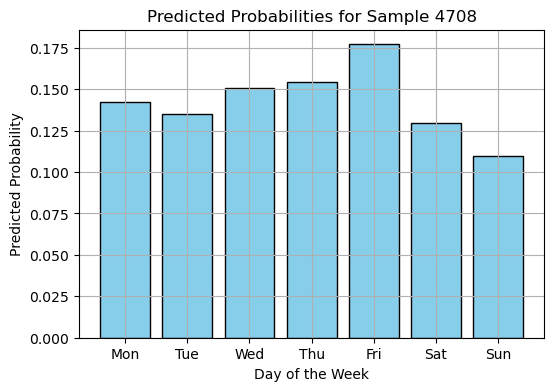

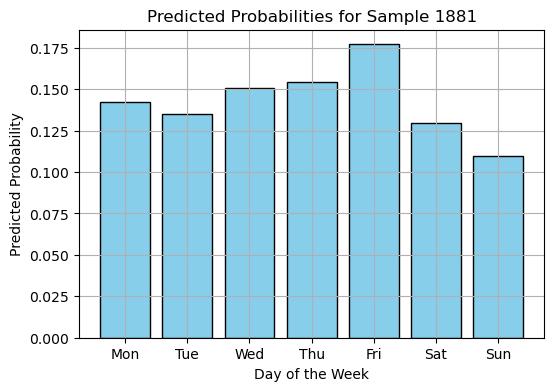

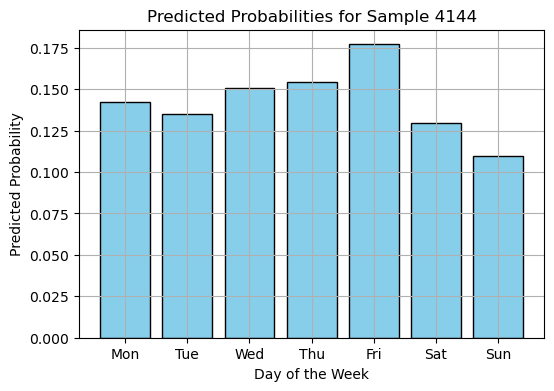

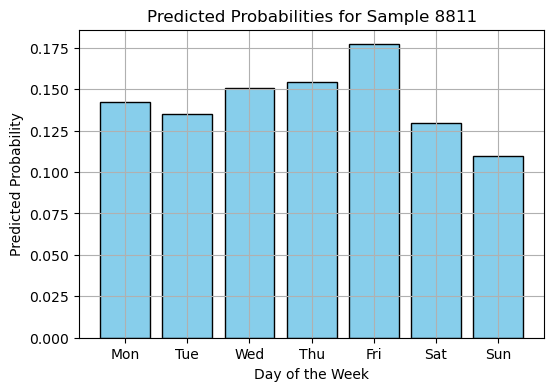

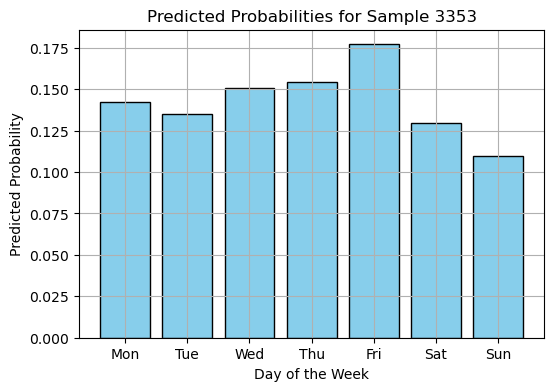

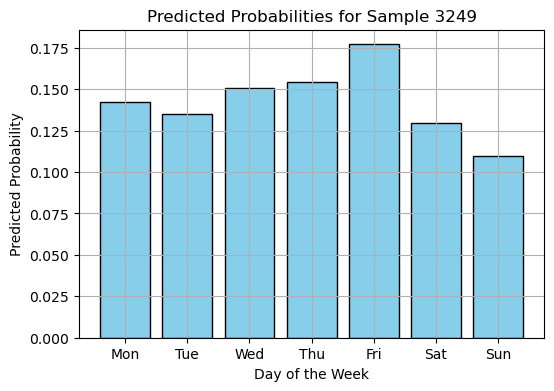

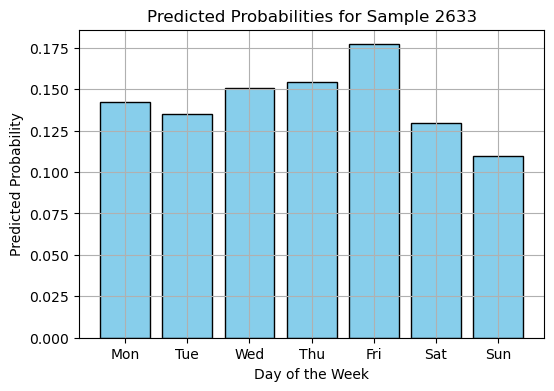

In [115]:
# Plot the predicted probabilities for the first sample in the test set
predicted_probs = model.predict(X_test_reshaped)

import numpy as np
import matplotlib.pyplot as plt
import random

# Get the predicted day of the week for each sample
predicted_days = np.argmax(predicted_probs, axis=1)



random_indices = random.sample(range(len(predicted_days)), 10)

# Plot predicted probabilities for each of the 10 random samples
for i in random_indices:
    plt.figure(figsize=(6, 4))
    plt.bar(range(7), predicted_probs[i], color='skyblue', edgecolor='black')
    plt.xlabel('Day of the Week')
    plt.ylabel('Predicted Probability')
    plt.title(f'Predicted Probabilities for Sample {i+1}')
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.grid(True)
    plt.show()



In [116]:
import numpy as np

# Calculate summary statistics for predicted probabilities
mean_probs = np.mean(predicted_probs, axis=0)
median_probs = np.median(predicted_probs, axis=0)
std_probs = np.std(predicted_probs, axis=0)
min_probs = np.min(predicted_probs, axis=0)
max_probs = np.max(predicted_probs, axis=0)

# Print summary statistics
print("Summary Statistics for Predicted Probabilities:")
print("Day of the Week\tMean\tMedian\tStd\tMin\tMax")
for day, mean, median, std, mini, maxi in zip(range(7), mean_probs, median_probs, std_probs, min_probs, max_probs):
    print(f"{day}\t\t{mean:.4f}\t{median:.4f}\t{std:.4f}\t{mini:.4f}\t{maxi:.4f}")


Summary Statistics for Predicted Probabilities:
Day of the Week	Mean	Median	Std	Min	Max
0		0.1424	0.1424	0.0000	0.1424	0.1424
1		0.1353	0.1353	0.0000	0.1353	0.1353
2		0.1509	0.1509	0.0000	0.1509	0.1509
3		0.1545	0.1545	0.0000	0.1545	0.1545
4		0.1771	0.1771	0.0000	0.1771	0.1771
5		0.1298	0.1298	0.0000	0.1298	0.1298
6		0.1100	0.1100	0.0000	0.1100	0.1100


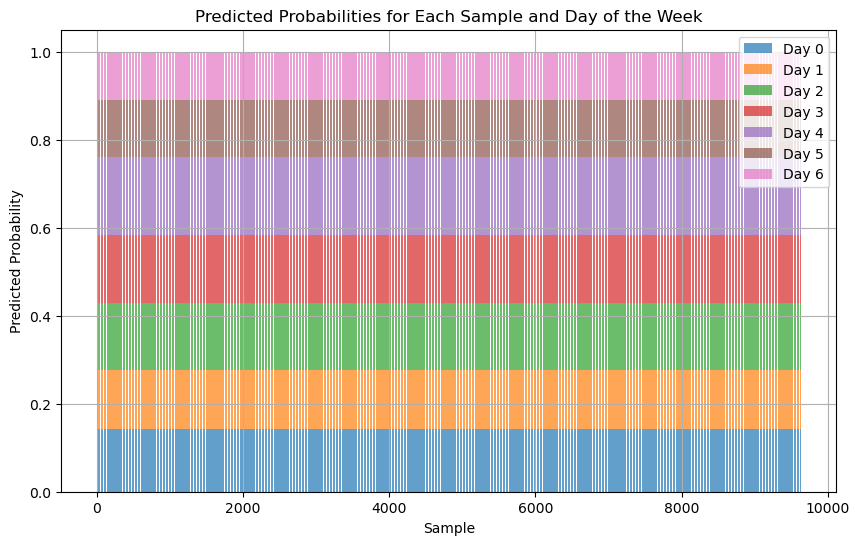

In [117]:
import matplotlib.pyplot as plt

# Sample indices for plotting
sample_indices = range(len(predicted_probs))

# Create a bar plot with stacked bars
plt.figure(figsize=(10, 6))
bottom = np.zeros(len(predicted_probs))
for i, day in enumerate(range(7)):
    plt.bar(sample_indices, predicted_probs[:, i], bottom=bottom, label=f'Day {day}', alpha=0.7)
    bottom += predicted_probs[:, i]

# Add labels and legend
plt.xlabel('Sample')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities for Each Sample and Day of the Week')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
